# Fitting a kinetic model to experimental data.
In this section we address the issue of how to yield a set of parameters that would fit to experimental data points. In other words, an attempt to find the congruence between the data and the proposed model. There is a plethora of mathematical approaches that can handle that task. Here, we implement the method of the $\chi^2_n$-criterion. The method exploits the principle of minimal squared deviation between a theoretical curve and an experimental one via scanning the entire parametric space. Once the minimum is located, one can also assess the parametric response of the system to small perturbations of the parameters' values. In order to estimate the latter we introduce so called deferential $\chi^2_n$ space.

In [2]:
#!/usr/bin/python

import sys
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import *
from scipy.optimize import root

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import matplotlib.gridspec as gridspec  # for unequal plot boxes

Firstly, we introduce the data points and define the kinetic system, the integration curves of which must be fitted to the points. The parameters have to be defined (it will note affect the outcome of the fitting procedure). It is important that the time points of the data and the time scale of integration are the same. 

In [3]:
#upload data: t1-time; s1=signal; d1-stdv
t1, s1, d1 = np.loadtxt('table.csv', skiprows=1, unpack=True)

#parameters description
k1  = 0.5
k2  = 2

#system of ODEs 
def syst(r, t=0):
  x,y = r
  x_t = k1*x
  y_t = k2*x

  return np.array([x_t, y_t])

#calculus of integration curves 
from scipy import integrate

t  = np.linspace(np.min(t1), np.max(t1), 20)            #time
I0 = np.array([1, 0])                                   #initials conditions: 1 'x' and 0 'y'
X, infodict = integrate.odeint(syst, I0, t, full_output=True)
print infodict['message']                               #integration report

Integration successful.


## Implementing $\chi^2_n$ -criterion for the best fit

Due to the peculiarities of a cell-free expression system, we would like to weight the data that has smaller uncertainty more heavily than those data that have greater uncertainty. For this case, there is a standard method of weighting and fitting data that is known as $\chi^2_n$ (or chi-squared) fitting. 

In this method we suppose that associated with each $(x_{i},y_{i})$ data point is an uncertainty in the value of $y_{i}$ of $\pm\sigma_{i}$. In this case, the “best fit” is defined as the the one with the set of fitting parameters that minimizes the sum

$$\chi^2_n = \sum_{i}^n \left(\frac{y_{i} - f(x_{i})} {\sigma_{i}}\right)^2 \;$$

What we do here is that we set up the boundaries of the scanning area via $k_1$, $k_2$ variables. Then we create a matrix in which every value of the scanned cell of the $\chi^2_n$ space will be stored.

In [4]:
dk    = 0.07 #step of surfing 

k1min = 0   #range of surfing
k1max = 5

k2min = 0 
k2max = 5

#matrix where to keep chi^2 values
flw = np.zeros((int((k1max-k1min)/dk), int((k2max-k2min)/dk)))

#scanning loop
for i in np.arange(int((k1max-k1min)/dk)):
  for j in np.arange(int((k2max-k2min)/dk)):
    k1 = k1min+i*dk
    k2 = k2min+j*dk
    X, infodict = integrate.odeint(syst, I0, t1, full_output=True)
    x, y = X.T
    chi=0       #begin the counting of chi^values at each point
    for p in np.arange(np.size(t1)):
      chi = (y[p]-s1[p])**2/(d1[p]**2)+chi
    flw[i,j] = math.log(chi/(np.size(t1)-2)) #normalize via log  

#return the indexes of the minimum values of an arbitrary matrix
def minimum(a): 
  minimum = np.min(a)
  index_of_minimum = np.where(a == minimum)
  return index_of_minimum
  
#******************pritn out parameters********************************

k1 = k1min + int(minimum(flw)[0])*dk
k2 = k2min + int(minimum(flw)[1])*dk
print 'Parameter analysis:'
print 'k1-value................ {0:0.2f}'.format(k1)     #best k1 fit
print 'k2-value................ {0:0.2f}'.format(k2)     #best k2 fit
print 'Error...................',dk

Parameter analysis:
k1-value................ 0.49
k2-value................ 2.03
Error................... 0.07


Once we have obtained the values of the parameters that minimize the squared deviation, we can proceed to the next step: estimation of the parametric "flexibility". In a $R^n$ space, it is difficult to estimate the "shape" of the fitting surface. A rough estimation of that would be $\nabla^n$ operator. Here we take the first derivative at the point of the best fit $k_1^*, k_2^*$ via 

$$
\nabla\chi^2_n(k_1,k_2) = \frac{\partial \chi^2_n }{\partial k_1} + \frac{\partial \chi^2_n }{\partial k_2} 
$$

Thus we take each component of the $\nabla$ over $\chi^2_n(k_1,k_2)$ and take the magnitude of these components (normalized on the scalar product of $\nabla\chi^2_n(k_1,k_2)$), considering them to be the system's parametric flexibility. Here we use Euler's method:

$$
\frac{\partial \chi^2_n }{\partial k_1} = \frac{ \chi^2_n(k_1^*+\Delta k,k_2^*)}{\Delta k} - \frac{ \chi^2_n(k_1^*,k_2^*)}{\Delta k} + o(\Delta k)
$$


In [5]:
#parametric flexibility: gradient componebts at the MIN!!!
ddk1 = (flw[int(minimum(flw)[0])+1,int(minimum(flw)[1])]-
	flw[int(minimum(flw)[0]),int(minimum(flw)[1])])/dk

ddk2 = (flw[int(minimum(flw)[0]),int(minimum(flw)[1])+1]-
	flw[int(minimum(flw)[0]),int(minimum(flw)[1])])/dk
norm = np.sqrt(ddk1**2+ddk2**2)  #normalize on the scalar product 

print 'k1-flexibility.......... {0:0.2f}'.format(ddk1/norm) 
print 'k2-flexibility.......... {0:0.2f}'.format(ddk2/norm) 

k1-flexibility.......... 0.98
k2-flexibility.......... 0.19


Now there comes the part for visualization of the fitting space along with the differential space:

It is quite obvious that if we wish to plot gradient at each point of the fitting sapce (i.e. differential space) we must sum these two coordinates ($\frac{\partial}{\partial k_1},\;\frac{\partial}{\partial k_2}$). The numerical method for the gradient takes the followoing appearance

$$
\nabla\chi^2_n(k_1,k_2) = \frac{\partial \chi^2_n }{\partial k_1} + \frac{\partial \chi^2_n }{\partial k_2} = \frac{1}{\Delta k}\left[\chi^2_n(k_1^*+\Delta k,k_2^*) - 2\chi^2_n(k_1^*,k_2^*) + \chi^2_n(k_1^*,k_2^*+\Delta k)  \right] + o(\Delta k)
$$

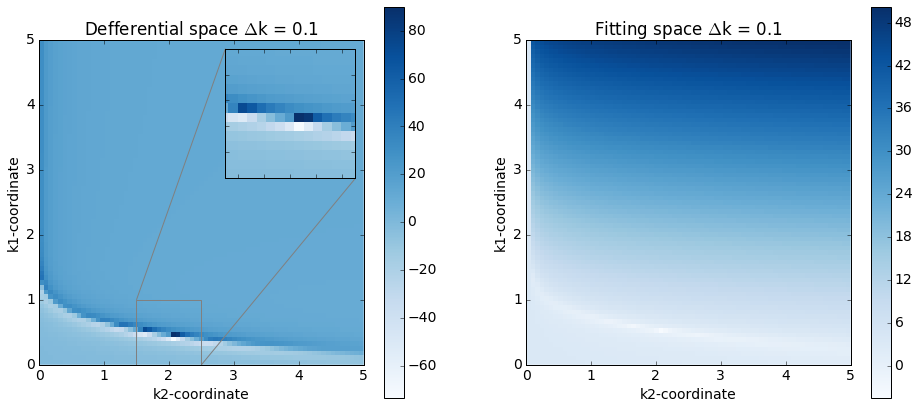

In [6]:
#*******************plotting gradient matrix *************************

dflw = np.zeros((int((k1max-k1min)/dk), int((k1max-k1min)/dk)))

for i in np.arange(int((k1max-k1min)/dk)-1):
  for j in np.arange(int((k2max-k2min)/dk)-1):
    #partial derivative at each point
    dflw[i,j] = (flw[i+1,j]-2*flw[i,j]+flw[i,j+1])/dk 

dflw1 = np.zeros((int((k1max-k1min)/dk)-2, int((k2max-k2min)/dk)-2))
#the edge cutout issue, for there are no points to calculate on the edges
#it will look like zero points on the map, we want everything to be cute 
for i in np.arange(int((k1max-k1min)/dk)-2):
  for j in np.arange(int((k2max-k2min)/dk)-2):
    dflw1[i,j]=dflw[i+1,j+1]


fig = plt.figure(1, figsize=(16,7))
plt.rc('font', size=14)

ax1 = fig.add_subplot(1,2,1)
plt.imshow(np.flipud(dflw1), cmap=plt.cm.Blues,
	   interpolation='none',extent=[k1min,k1max,k2min,k2max])
ax1 = plt.gca()
ax1.set_xlabel('k2-coordinate')
ax1.set_ylabel('k1-coordinate')
plt.title('Defferential space $\Delta$k = 0.1' )
plt.colorbar()

axins1 = zoomed_inset_axes(ax1, 2, loc=1)  # zoom = 2
axins1.imshow(np.flipud(dflw1), cmap=plt.cm.Blues,
	   interpolation='none',extent=[k1min,k1max,k2min,k2max])

# sub region of the original image
x1, x2, y1, y2 = 1.5, 2.5, 0, 1
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
axins1.yaxis.get_major_locator().set_params(nbins=7)
axins1.xaxis.get_major_locator().set_params(nbins=7)

plt.setp(axins1.get_xticklabels(), visible=False)
plt.setp(axins1.get_yticklabels(), visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="0.5")


ax2 = fig.add_subplot(1,2,2)
plt.imshow(np.flipud(flw), cmap=plt.cm.Blues,
	   interpolation='none',extent=[k1min,k1max,k2min,k2max])
ax2 = plt.gca()
ax2.set_xlabel('k2-coordinate')
ax2.set_ylabel('k1-coordinate')
plt.title('Fitting space $\Delta$k = 0.1' )
plt.colorbar()

plt.show()  

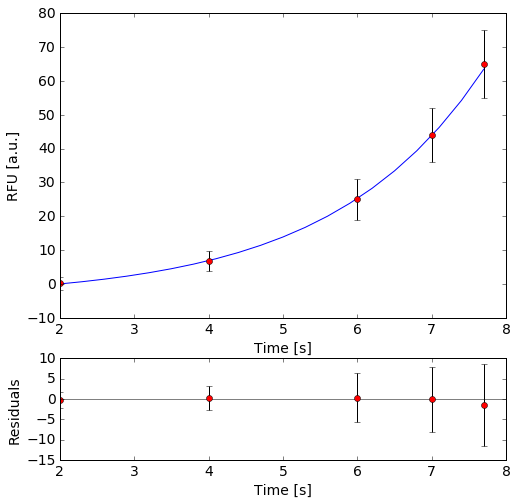

In [7]:
#calculate residuals
X, infodict = integrate.odeint(syst, I0, t1, full_output=True)
x, y = X.T

resids = y - s1

#smooth curve 
R, infodict = integrate.odeint(syst, I0, t, full_output=True)
x0, y0 = R.T

#lets plot!

fig = plt.figure(2, figsize=(8,8))
plt.rc('font', size=14)

fig = plt.figure(2, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])

# Top plot: data and fit
ax1 = fig.add_subplot(gs[0])
ax1.plot(t, y0)
ax1.errorbar(t1, s1, yerr=d1, fmt='or', ecolor='black')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('RFU [a.u.]')

# Bottom plot: residuals
ax2 = fig.add_subplot(gs[1])
ax2.errorbar(t1, resids, yerr = d1, ecolor="black", fmt="ro")
ax2.axhline(color="gray", zorder=-1)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Residuals')